<a href="https://colab.research.google.com/github/syilmazs/DeepLearning/blob/main/DL_Assignmet_3_(RNN_Time_Series_Frozen_Dessert_Production).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Product Amount Forecast by Time

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

## Import Libraries

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (12,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

## Indest Data

In [4]:
df = pd.read_csv("/content/Frozen_Dessert_Production.csv", index_col="DATE", parse_dates=True)
df.head()

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


## Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Change the column name as "Production"
2. Plot your data and see its seasonalty

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [22]:
df.shape

(573, 1)

In [9]:
df=df.rename(columns = {'IPN31152N':'Production'})

In [16]:
df

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


<Figure size 1440x576 with 0 Axes>

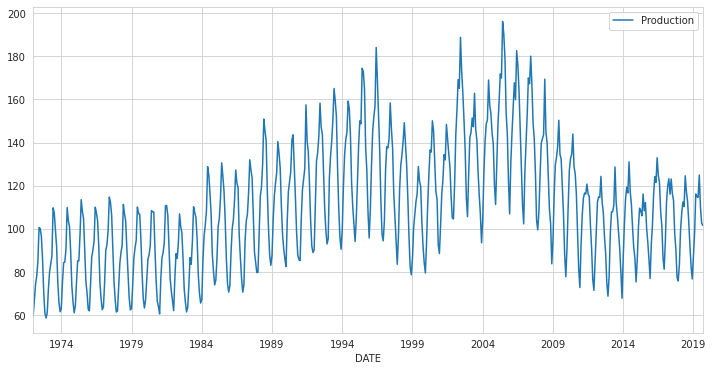

In [21]:
plt.figure(figsize=(20,8))
df.plot();

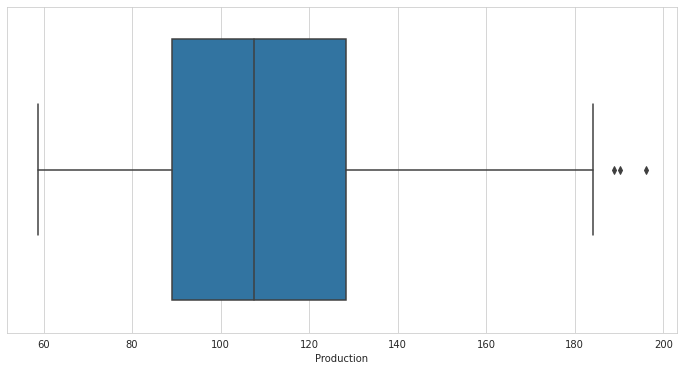

In [32]:
sns.boxplot(df.Production)

## Preprocessing of Data

### Train Test Split

In [24]:
len(df)

573

In [27]:
test_ind = 36

In [28]:
train = df.iloc[:-test_ind]
test = df.iloc[-test_ind:]

In [29]:
train.shape, test.shape

((537, 1), (36, 1))

### Scaling

In [34]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [35]:
scaler = StandardScaler()

In [36]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [39]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [40]:
length = 12 # Length of the output sequences (in number of timesteps)
batch_size = 1 #Number of timeseries samples in each batch  
generator = TimeseriesGenerator(train_scaled, train_scaled, length=length, batch_size=batch_size)
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length=length, batch_size=batch_size)

In [42]:
len(train_scaled), len(generator), len(test_scaled), len(validation_generator)

(537, 525, 36, 24)

## Modelling & Model Performance

### Import related libraries

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping

### Creating Model

### with "tanh" activation function

In [48]:
train_scaled.shape[1] # feature sayısı

1

In [49]:
n_features = train_scaled.shape[1]

In [50]:
model = Sequential()

model.add(LSTM(100,activation = 'tanh', return_sequences=True, input_shape=(length, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(n_features)) 

model.compile(optimizer='adam', loss='mse')

In [51]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)

In [52]:
model.fit_generator(generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stop])

Epoch 1/100
525/525 [==============================] - 12s 15ms/step - loss: 0.2527 - val_loss: 0.0516
Epoch 2/100
525/525 [==============================] - 7s 13ms/step - loss: 0.0860 - val_loss: 0.0555
Epoch 3/100
525/525 [==============================] - 6s 12ms/step - loss: 0.0783 - val_loss: 0.0541
Epoch 4/100
525/525 [==============================] - 7s 12ms/step - loss: 0.0741 - val_loss: 0.0518
Epoch 5/100
525/525 [==============================] - 7s 13ms/step - loss: 0.0635 - val_loss: 0.0472
Epoch 6/100
525/525 [==============================] - 8s 15ms/step - loss: 0.0651 - val_loss: 0.0368
Epoch 7/100
525/525 [==============================] - 8s 14ms/step - loss: 0.0594 - val_loss: 0.0382
Epoch 8/100
525/525 [==============================] - 9s 18ms/step - loss: 0.0551 - val_loss: 0.0850
Epoch 9/100
525/525 [==============================] - 11s 21ms/step - loss: 0.0564 - val_loss: 0.0422
Epoch 10/100
525/525 [==============================] - 9s 18ms/step - loss: 0.0

#### Evaluate on Test Data

In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [54]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [55]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [56]:
predictions_scaled

[array([-0.45827758], dtype=float32),
 array([-0.7774402], dtype=float32),
 array([-1.0626984], dtype=float32),
 array([-0.65094453], dtype=float32),
 array([-0.08309519], dtype=float32),
 array([0.33437413], dtype=float32),
 array([0.5269375], dtype=float32),
 array([0.6011926], dtype=float32),
 array([1.0184458], dtype=float32),
 array([0.81809634], dtype=float32),
 array([0.70715743], dtype=float32),
 array([0.32700843], dtype=float32)]

In [57]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.32849085710807646 
mae: 0.2930229722518474 
mse: 0.15604662594478272 
rmse: 0.3950273736651458


#### Inverse Transformations and Comparing

In [58]:
predictions = scaler.inverse_transform(predictions_scaled)

In [61]:
compare = test[:12]

In [62]:
compare['Predictions'] = predictions
compare

,Production,Predictions
DATE,,
2016-10-01,101.384,97.254
2016-11-01,86.665,88.145
2016-12-01,81.257,80.004
2017-01-01,94.245,91.755
2017-02-01,112.388,107.961
2017-03-01,119.698,119.876
2017-04-01,123.228,125.371
2017-05-01,116.064,127.491
2017-06-01,123.087,139.399


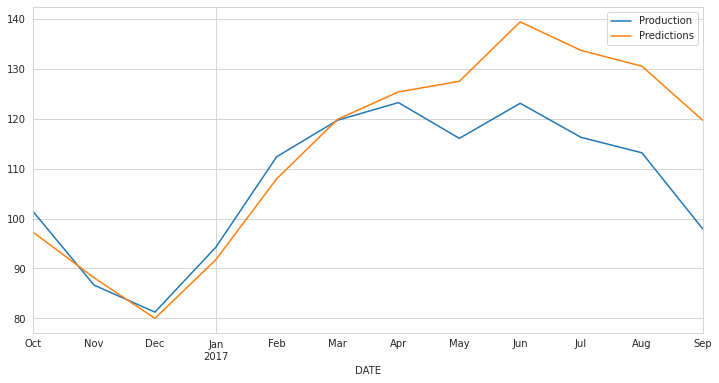

In [63]:
compare.plot()

#### Calculation R2 Score and Error Metrics

In [64]:
eval_metrics(compare.Production, compare.Predictions)

r2_score: 0.3284908571080766 
mae: 8.362820502854076 
mse: 127.10323224683457 
rmse: 11.27400692951865


### with "relu" activation function

In [65]:
model = Sequential()

model.add(LSTM(100,activation = 'relu', return_sequences=True, input_shape=(length, n_features)))
model.add(LSTM(50, activation = 'relu'))
model.add(Dense(n_features)) 

model.compile(optimizer='adam', loss='mse')

In [66]:
model.fit_generator(generator,
                    epochs=50,
                    validation_data=validation_generator,
                    callbacks=[early_stop])

Epoch 1/50
525/525 [==============================] - 10s 13ms/step - loss: 0.5106 - val_loss: 0.1735
Epoch 2/50
525/525 [==============================] - 6s 12ms/step - loss: 0.1693 - val_loss: 0.0760
Epoch 3/50
525/525 [==============================] - 6s 11ms/step - loss: 0.1448 - val_loss: 0.0405
Epoch 4/50
525/525 [==============================] - 5s 10ms/step - loss: 0.1207 - val_loss: 0.0519
Epoch 5/50
525/525 [==============================] - 6s 11ms/step - loss: 0.1063 - val_loss: 0.0472
Epoch 6/50
525/525 [==============================] - 6s 11ms/step - loss: 0.1032 - val_loss: 0.0530
Epoch 7/50
525/525 [==============================] - 5s 10ms/step - loss: 0.0931 - val_loss: 0.0531
Epoch 8/50
525/525 [==============================] - 6s 12ms/step - loss: 0.0816 - val_loss: 0.0696
Epoch 9/50
525/525 [==============================] - 6s 11ms/step - loss: 0.0802 - val_loss: 0.0510
Epoch 10/50
525/525 [==============================] - 6s 12ms/step - loss: 0.0784 - val_l

#### Evaluate on Test Data

In [67]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [68]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [69]:
predictions_scaled

[array([-0.47410992], dtype=float32),
 array([-0.83807904], dtype=float32),
 array([-1.0063941], dtype=float32),
 array([-0.6081631], dtype=float32),
 array([-0.17628443], dtype=float32),
 array([0.20033163], dtype=float32),
 array([0.4695726], dtype=float32),
 array([0.6772713], dtype=float32),
 array([0.88335145], dtype=float32),
 array([0.97434795], dtype=float32),
 array([0.84992146], dtype=float32),
 array([0.42220265], dtype=float32)]

In [70]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.1358817524721544 
mae: 0.3256116617450611 
mse: 0.20080551154273893 
rmse: 0.4481132798107404


#### Inverse Transformations and Comparing

In [71]:
predictions = scaler.inverse_transform(predictions_scaled)

In [72]:
compare = test[:12]

In [73]:
compare['Predictions'] = predictions
compare

,Production,Predictions
DATE,,
2016-10-01,101.384,96.802
2016-11-01,86.665,86.414
2016-12-01,81.257,81.610
2017-01-01,94.245,92.976
2017-02-01,112.388,105.302
2017-03-01,119.698,116.050
2017-04-01,123.228,123.734
2017-05-01,116.064,129.662
2017-06-01,123.087,135.543


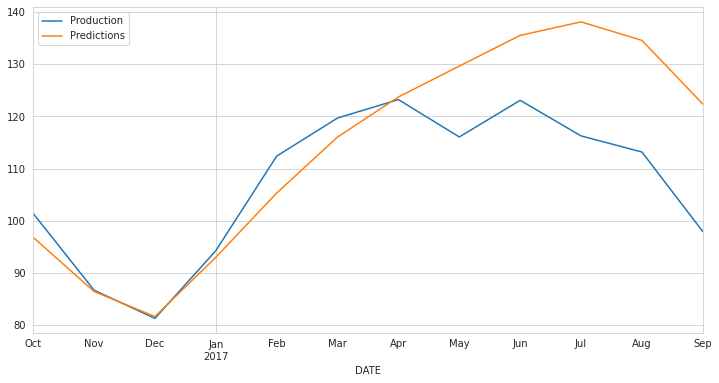

In [74]:
compare.plot()

#### Calculation R2 Score and Error Metrics

In [75]:
eval_metrics(compare.Production, compare.Predictions)

r2_score: 0.13588175247215406 
mae: 9.292895570213492 
mse: 163.5602783176647 
rmse: 12.789068704079462


## Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [76]:
full_scaler = StandardScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [77]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [78]:
len(df), len(generator)

(573, 561)

In [79]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=50)

Epoch 1/50
561/561 [==============================] - 12s 14ms/step - loss: 0.3095
Epoch 2/50
561/561 [==============================] - 6s 11ms/step - loss: 0.1011
Epoch 3/50
561/561 [==============================] - 9s 15ms/step - loss: 0.0799
Epoch 4/50
561/561 [==============================] - 7s 12ms/step - loss: 0.0725
Epoch 5/50
561/561 [==============================] - 7s 12ms/step - loss: 0.0627
Epoch 6/50
561/561 [==============================] - 8s 15ms/step - loss: 0.0708
Epoch 7/50
561/561 [==============================] - 10s 17ms/step - loss: 0.0606
Epoch 8/50
561/561 [==============================] - 10s 18ms/step - loss: 0.0562
Epoch 9/50
561/561 [==============================] - 11s 19ms/step - loss: 0.0534
Epoch 10/50
561/561 [==============================] - 9s 16ms/step - loss: 0.0532
Epoch 11/50
561/561 [==============================] - 10s 18ms/step - loss: 0.0493
Epoch 12/50
561/561 [==============================] - 10s 17ms/step - loss: 0.0518
Epoch 1

In [81]:
scaled_full_data.shape

(573, 1)

In [82]:
scaled_full_data[-length:].shape

(12, 1)

In [93]:
forecast = []
# Replace periods with whatever forecast length you want

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(3*length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [94]:
forecast = scaler.inverse_transform(forecast)

In [95]:
forecast

array([[ 91.60961343],
       [ 83.28061889],
       [ 73.92105221],
       [ 89.57051376],
       [105.63513687],
       [119.60212358],
       [127.1151302 ],
       [131.19867441],
       [132.23460845],
       [119.57295983],
       [110.01273118],
       [ 99.24133849],
       [ 90.98408467],
       [ 83.87976181],
       [ 76.64222538],
       [ 93.04040463],
       [109.1684458 ],
       [117.09552146],
       [123.07364071],
       [133.938638  ],
       [128.66477933],
       [119.81039756],
       [108.2014227 ],
       [ 97.67385667],
       [ 89.67315335],
       [ 82.57087351],
       [ 76.87415068],
       [ 95.23404122],
       [111.12955873],
       [119.47619245],
       [124.56360486],
       [138.00786061],
       [128.12771996],
       [119.83587331],
       [107.10123579],
       [ 96.7161922 ]])

In [96]:
df

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


In [99]:
forecast_index = pd.date_range(start = '2019-10-01', periods = 3*length, freq = 'MS')

In [100]:
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01',
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [101]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [102]:
forecast_df

,Forecast
2019-10-01,91.610
2019-11-01,83.281
2019-12-01,73.921
2020-01-01,89.571
2020-02-01,105.635
2020-03-01,119.602
2020-04-01,127.115
2020-05-01,131.199
2020-06-01,132.235
2020-07-01,119.573


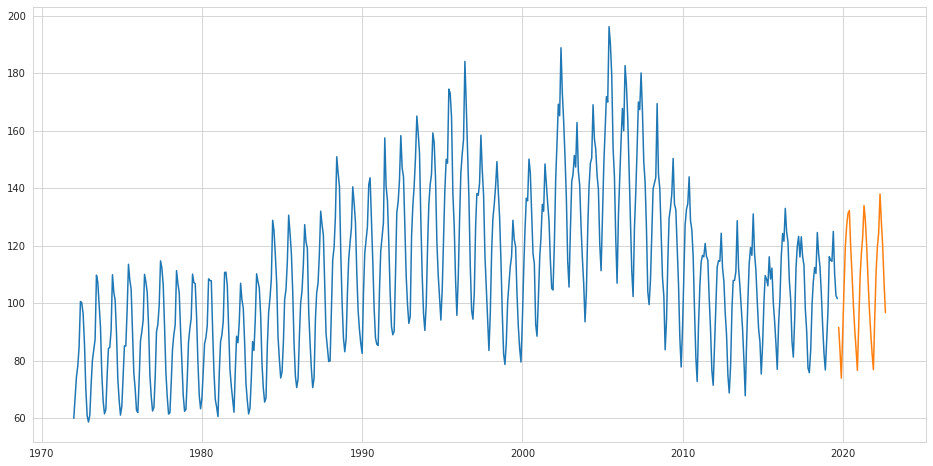

In [103]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['Production'])
plt.plot(forecast_df.index, forecast_df['Forecast'])